## Airbnb Explorer NYC

In [227]:
import numpy as np
import pandas as pd
import plotly.express as px
from dash import Dash, html, dcc, Input, Output
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns

In [246]:
df = pd.read_csv('data/AB_NYC_2019.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


## Room type frequency on AirBNB

In [229]:
df["room_type"].value_counts(normalize=True).apply(lambda x: x*100).reset_index()

,index,room_type
0,Entire home/apt,51.966459
1,Private room,45.661111
2,Shared room,2.372431


## Distribution of AirBNB by neighborhood and neighborhood group

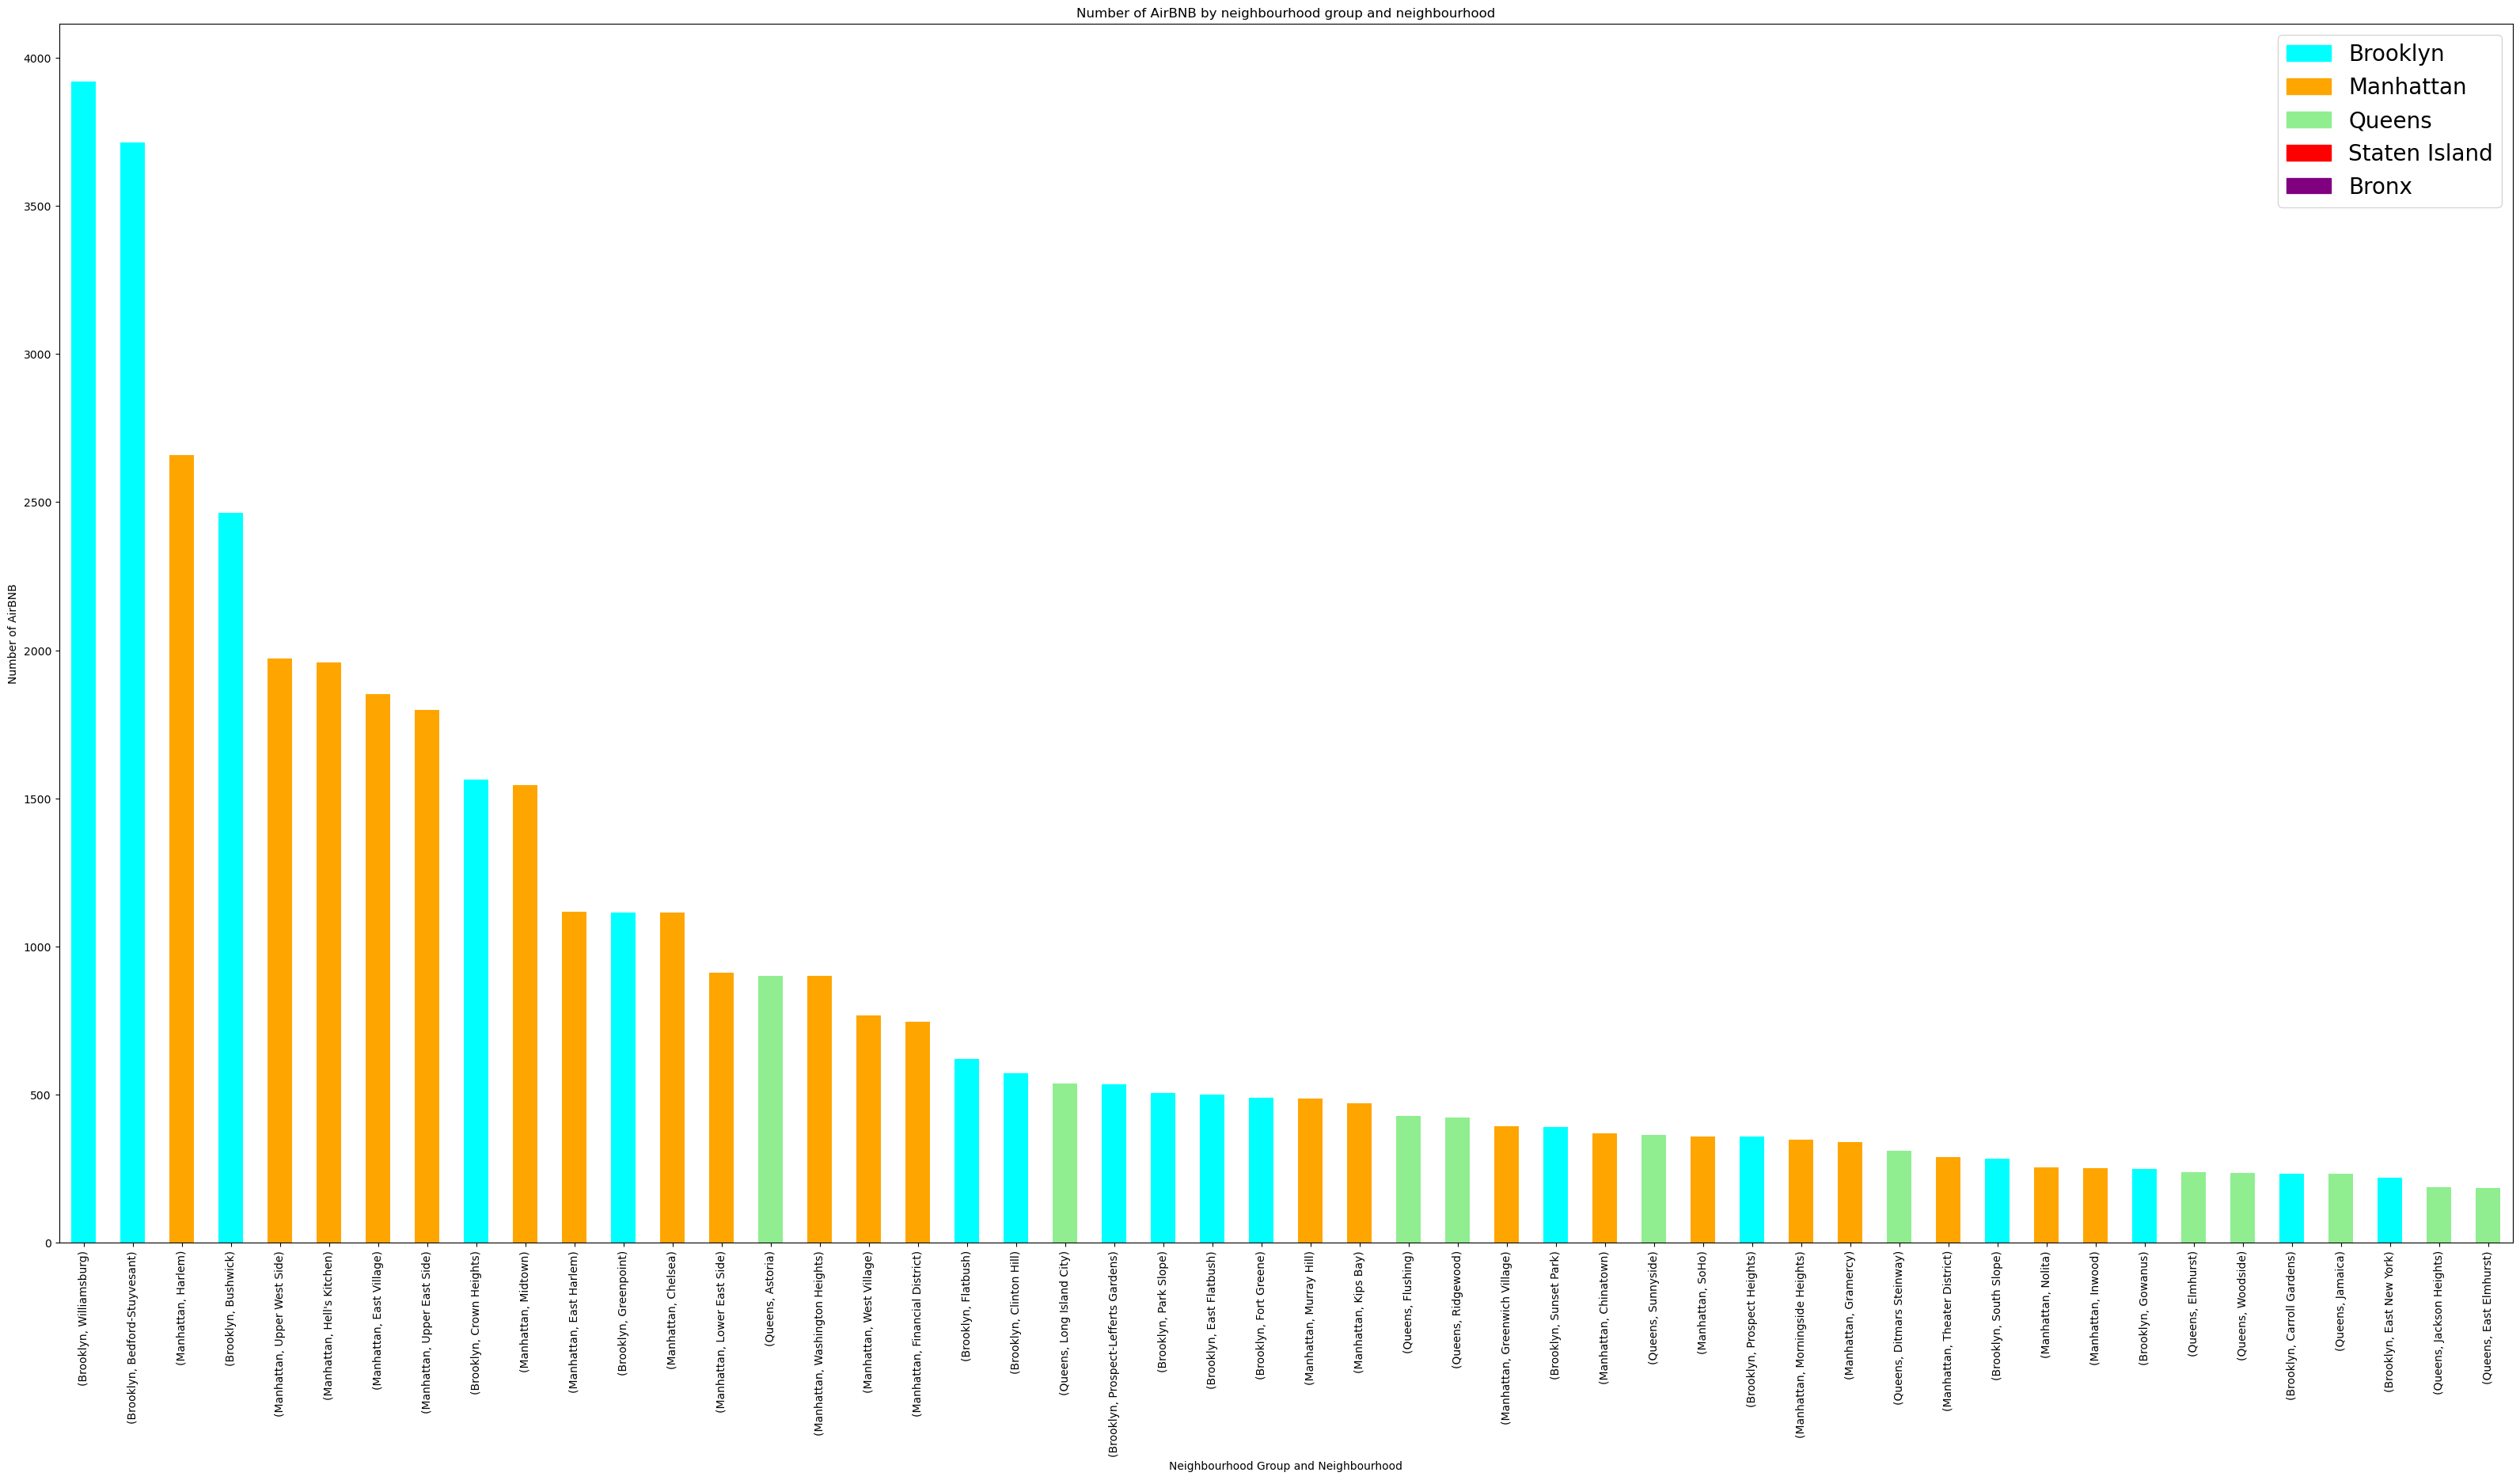

In [230]:
df_neighbourhood = df.groupby(["neighbourhood_group", "neighbourhood"]).size()
df_neighbourhood = df_neighbourhood.sort_values(ascending=False)
df_neighbourhood = df_neighbourhood[:50]
color_mapping = {'Brooklyn': 'cyan', 'Manhattan': 'orange', 'Queens': 'lightgreen', 'Staten Island': 'red', 'Bronx': 'purple'}
plt.figure(figsize=(40,20))
df_neighbourhood.plot(kind='bar', color=[color_mapping[i] for i in df_neighbourhood.index.get_level_values(0)])
plt.title("Number of AirBNB by neighbourhood group and neighbourhood")
handles = [plt.Rectangle((0,0),1,1, color=color_mapping[label]) for label in color_mapping]
labels = color_mapping.keys()
plt.legend(handles, labels, fontsize=20)
plt.xlabel("Neighbourhood Group and Neighbourhood")
plt.ylabel("Number of AirBNB")
plt.show()

## Distribution of AirBNB price

In [231]:
df["price"].describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

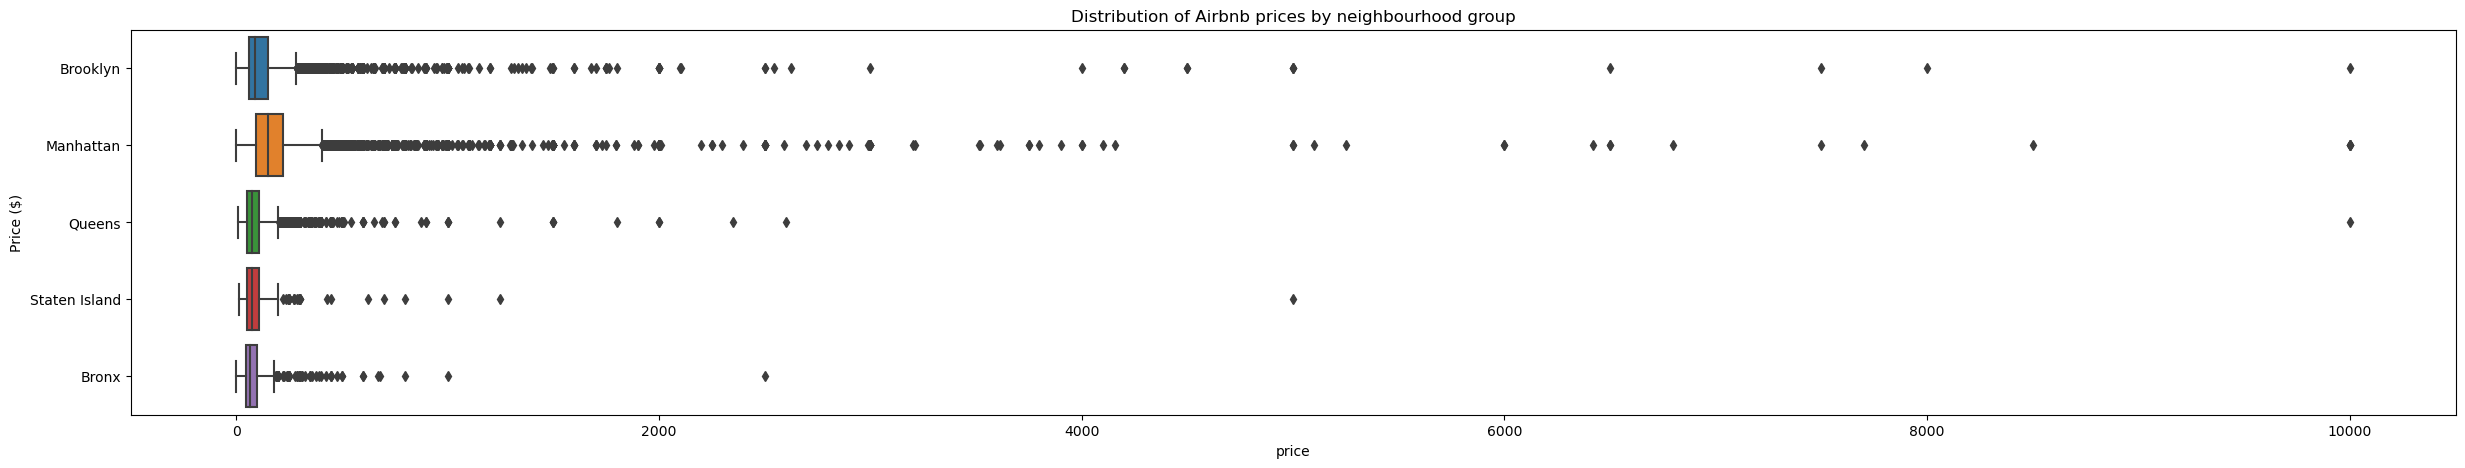

In [232]:
plt.figure(figsize=(30,5))
sns.boxplot(x="price", y="neighbourhood_group", data=df)
plt.title('Distribution of Airbnb prices by neighbourhood group')
plt.ylabel('Price ($)')
plt.show()

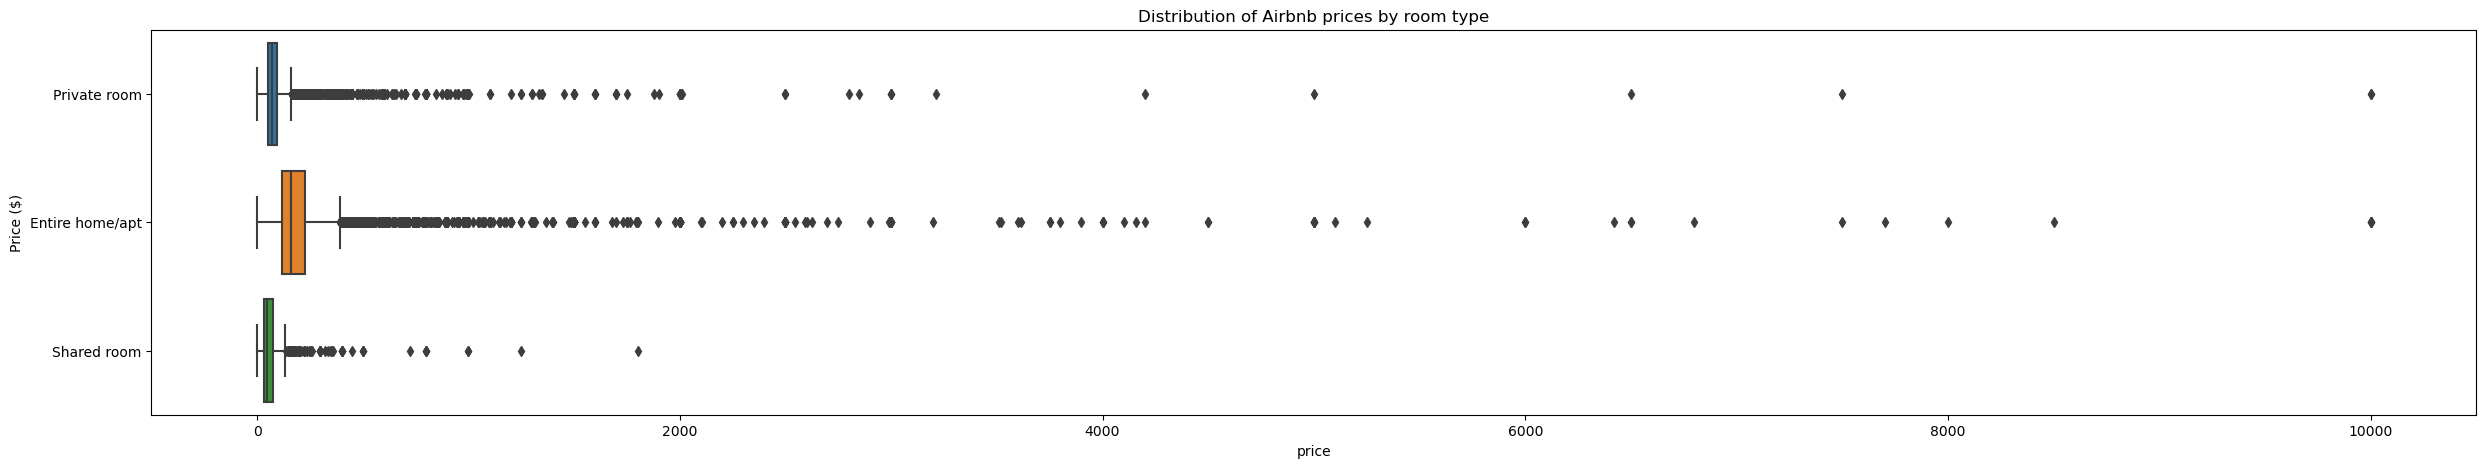

In [233]:
plt.figure(figsize=(30,5))
sns.boxplot(x="price", y="room_type", data=df)
plt.title('Distribution of Airbnb prices by room type')
plt.ylabel('Price ($)')
plt.show()

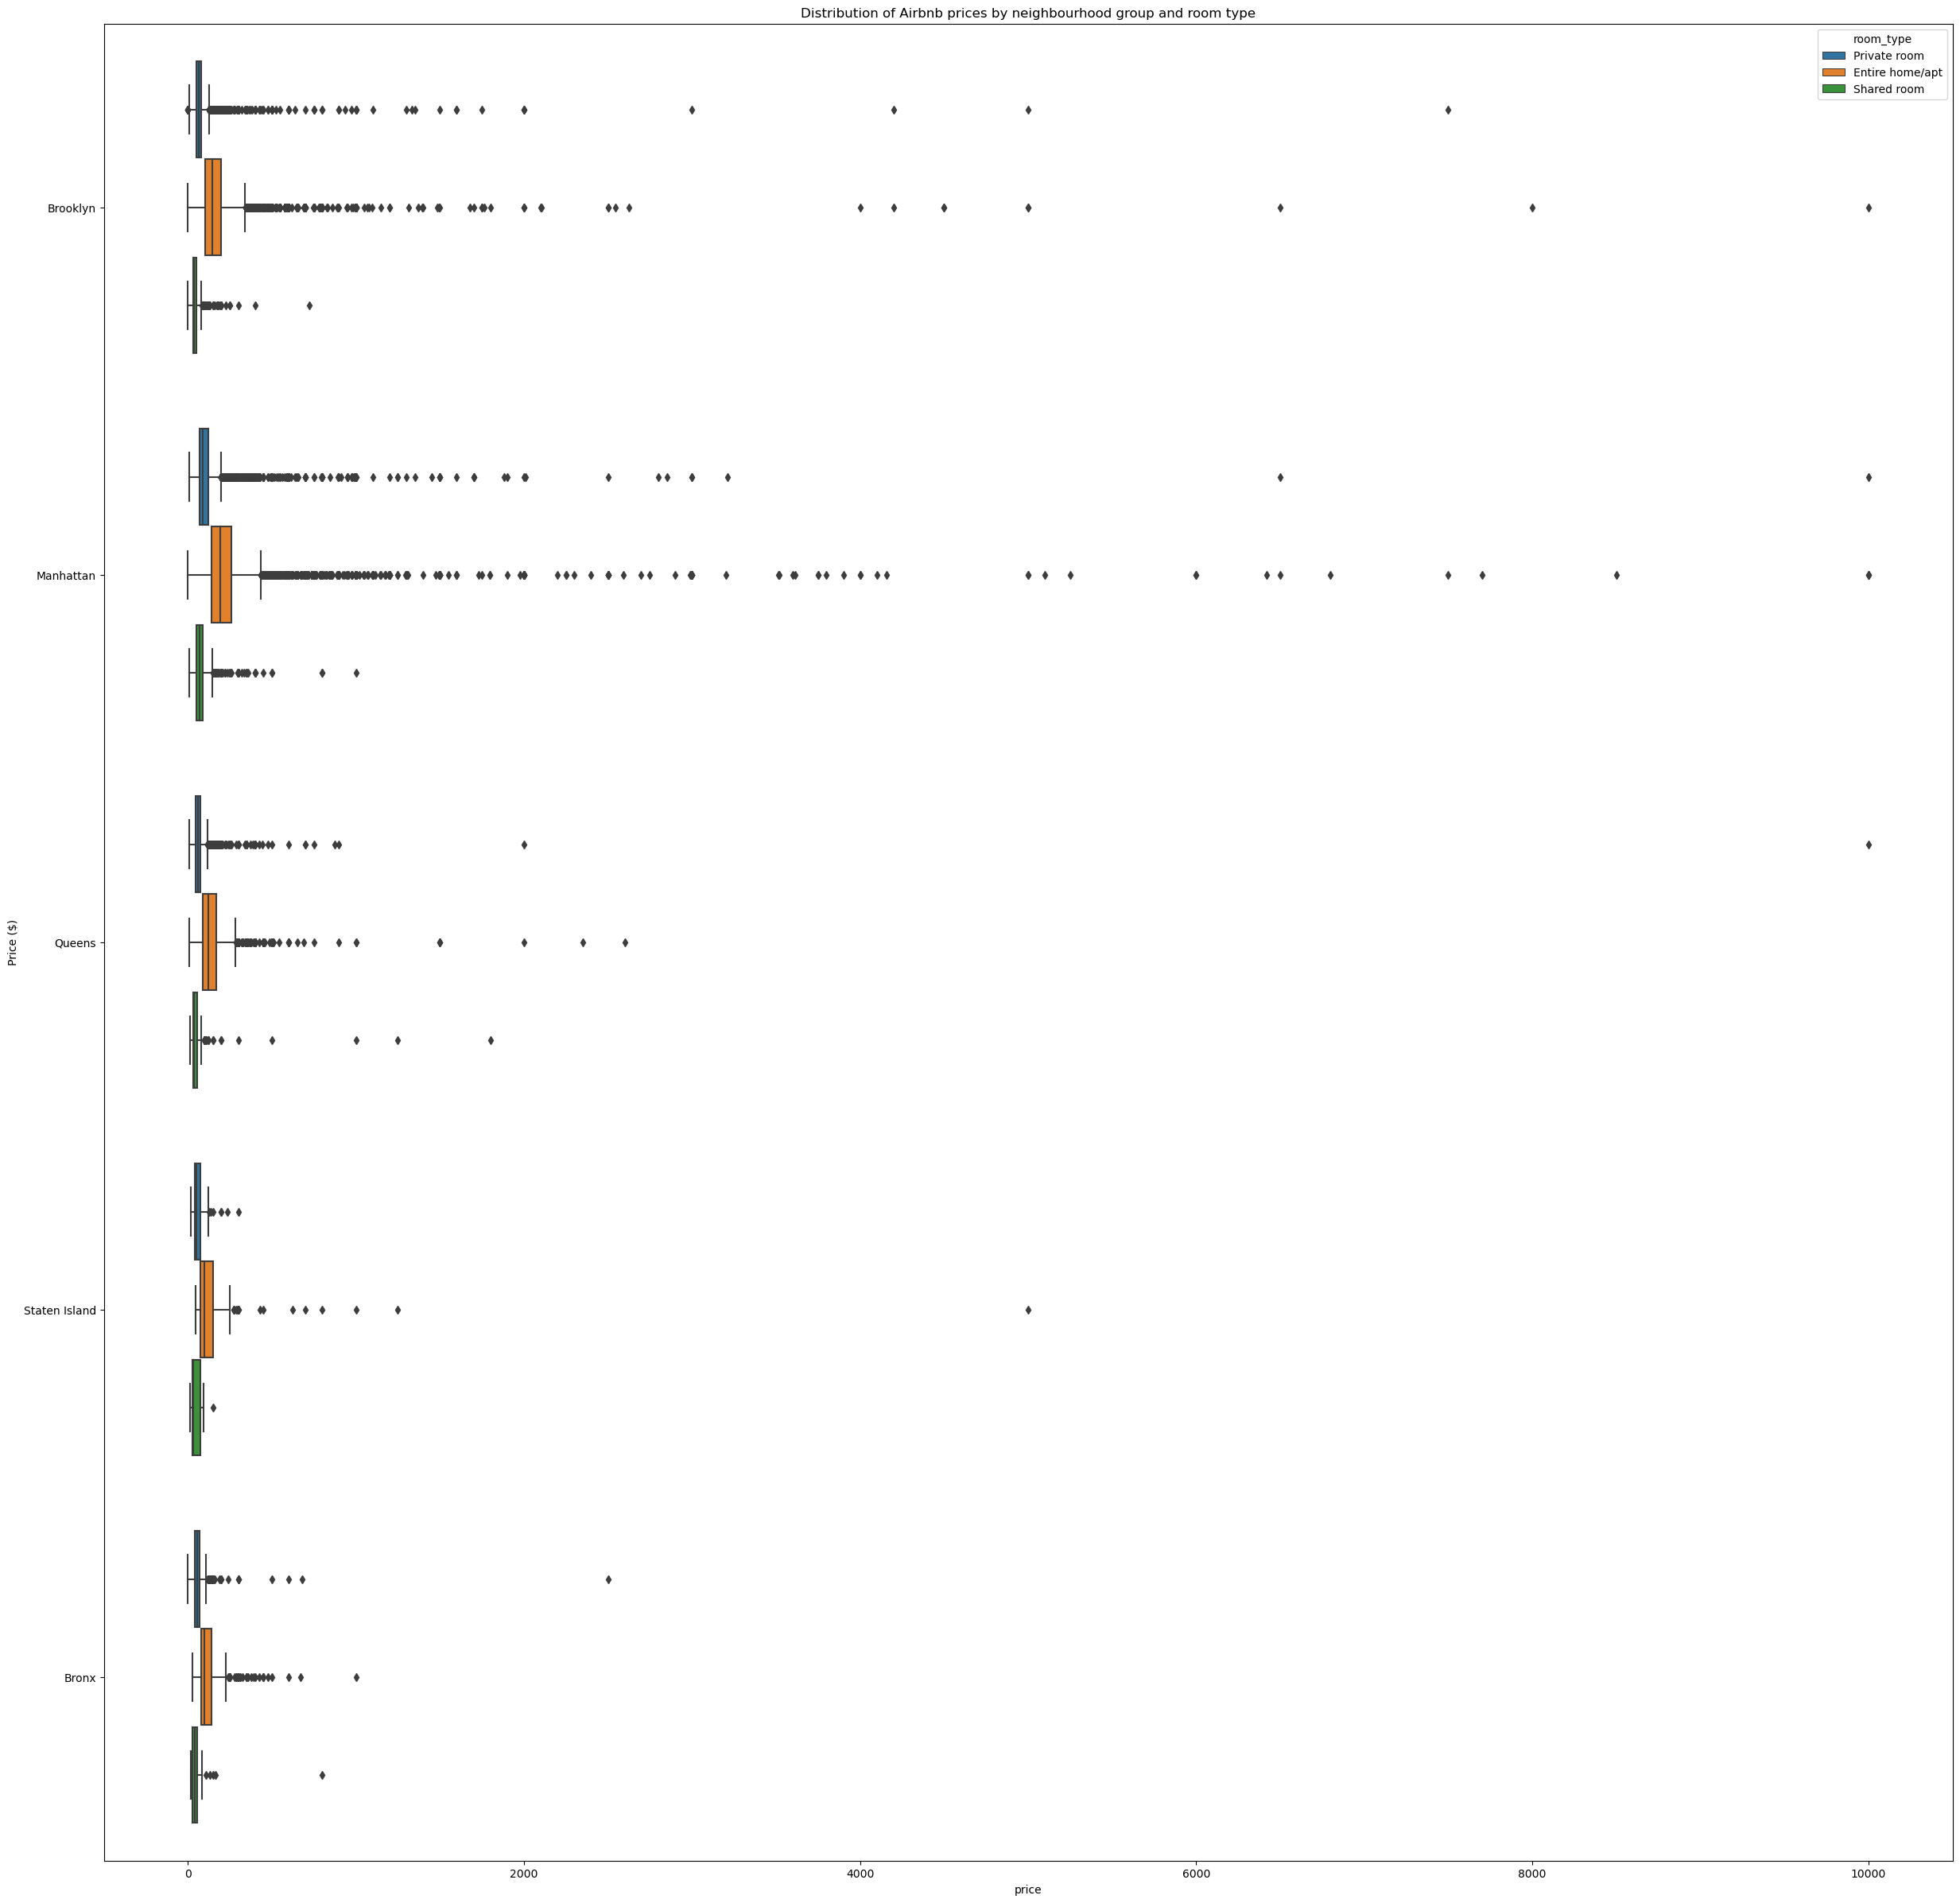

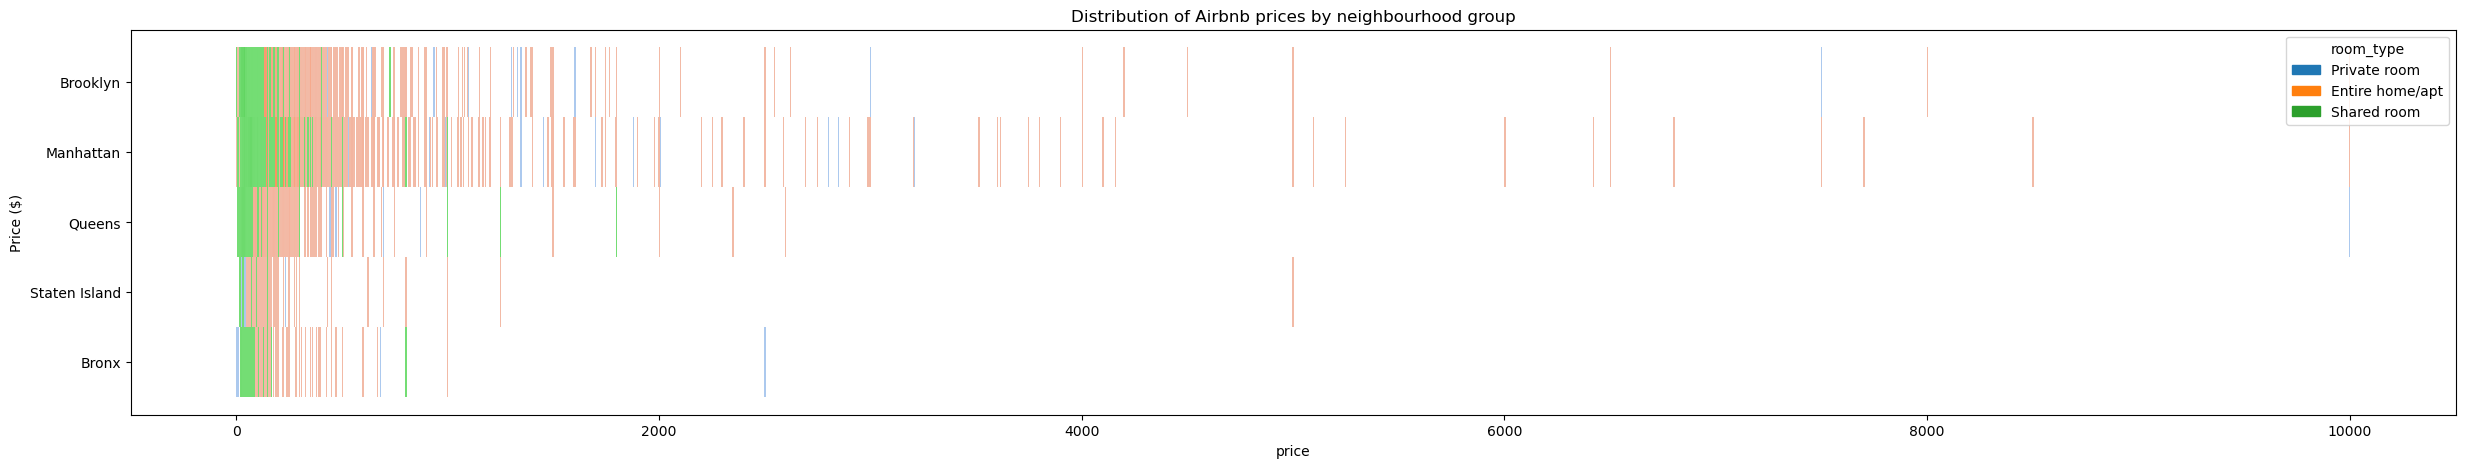

In [234]:
# Distribution of prices according to the neighbourhood group and the room type
plt.figure(figsize=(30,30))
sns.boxplot(x="price", y="neighbourhood_group", hue="room_type", data=df)
plt.title('Distribution of Airbnb prices by neighbourhood group and room type')
plt.ylabel('Price ($)')
plt.show()

# Plot it in histogram
plt.figure(figsize=(30,5))
sns.histplot(data=df, x="price", y="neighbourhood_group", hue="room_type")
plt.title('Distribution of Airbnb prices by neighbourhood group')
plt.ylabel('Price ($)')
plt.show()

## Comments and reviews

In [235]:
df["reviews_per_month"].describe()

count    38843.000000
mean         1.373221
std          1.680442
min          0.010000
25%          0.190000
50%          0.720000
75%          2.020000
max         58.500000
Name: reviews_per_month, dtype: float64

## Prediction

In [247]:
df['id'] = range(1, len(df) + 1)
df_train = df.sample(frac=0.8, random_state=0).query('price > 0')
df_test = df.loc[~df.index.isin(df_train.index)].query('price > 0')
df_test.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
10,11,Beautiful 1br on Upper West Side,7702,Lena,Manhattan,Upper West Side,40.80316,-73.96545,Entire home/apt,135,5,53,2019-06-22,0.43,1,6
11,12,Central Manhattan/near Broadway,7989,Kate,Manhattan,Hell's Kitchen,40.76076,-73.98867,Private room,85,2,188,2019-06-23,1.50,1,39
13,14,Wonderful Guest Bedroom in Manhattan for SINGLES,11528,Claudio,Manhattan,Upper West Side,40.79826,-73.96113,Private room,85,2,113,2019-07-05,0.91,1,333
19,20,Huge 2 BR Upper East Cental Park,17985,Sing,Manhattan,East Harlem,40.79685,-73.94872,Entire home/apt,190,7,0,NaN,NaN,2,249
21,22,CBG CtyBGd HelpsHaiti rm#1:1-4,22486,Lisel,Brooklyn,Park Slope,40.68069,-73.97706,Private room,130,2,130,2019-07-01,1.09,6,347


In [252]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Filtrer les données
filtered_data = df_train[(df_train['price'] < np.quantile(df_train['price'], 0.9)) & (df_train['price'] > np.quantile(df_train['price'], 0.1))].copy()
filtered_data.dropna(inplace=True)

# Encodage one-hot des variables catégorielles
encoded_data = pd.get_dummies(filtered_data, columns=['room_type', 'neighbourhood_group'])

# Définir les variables dépendantes et indépendantes
X = encoded_data[['room_type_Entire home/apt', 'room_type_Private room', 'room_type_Shared room', 'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island', 'latitude', 'longitude', 'number_of_reviews', 'availability_365', 'reviews_per_month', 'calculated_host_listings_count', 'minimum_nights']].copy()
y = np.log(encoded_data['price'])

# Créer le modèle linéaire
price_model = sm.OLS(y, X).fit()

# Résumer les résultats
print(price_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     1900.
Date:                Thu, 25 May 2023   Prob (F-statistic):               0.00
Time:                        19:31:04   Log-Likelihood:                -7003.3
No. Observations:               25205   AIC:                         1.403e+04
Df Residuals:                   25191   BIC:                         1.415e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
room_t

In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

filtered_data = df_test[(df_test['price'] < np.quantile(df_test['price'], 0.9)) & (df_test['price'] > np.quantile(df_test['price'], 0.1))].copy()
filtered_data.dropna(inplace=True)
encoded_data = pd.get_dummies(filtered_data, columns=['room_type', 'neighbourhood_group'])

X_test = encoded_data[['room_type_Entire home/apt', 'room_type_Private room', 'room_type_Shared room', 'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island', 'latitude', 'longitude', 'number_of_reviews', 'availability_365', 'reviews_per_month', 'calculated_host_listings_count', 'minimum_nights']].copy()

pred_regression = price_model.predict(X_test)
pred_regression = np.exp(pred_regression)

print('RMSE: ', np.sqrt(mean_squared_error(filtered_data['price'], pred_regression)))

RMSE:  41.2757917256844


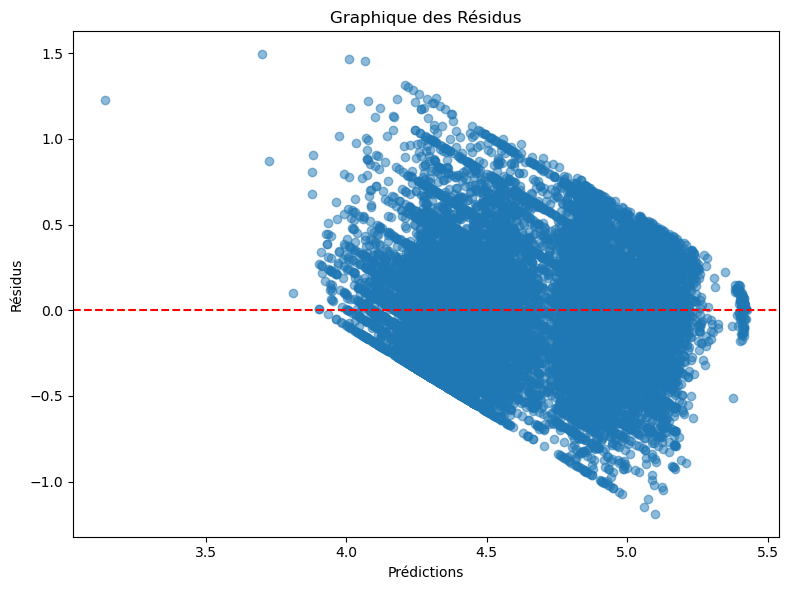

In [ ]:
app = Dash(__name__)

app.layout = html.Div([
    html.H1("Airbnb Explorer NYC"),
])

if __name__ == "__main__":
    app.run(debug=True, port=4000, use_reloader=False)

Dash is running on http://127.0.0.1:4000/

 * Serving Flask app '__main__'
 * Debug mode: on
